In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import csv
import os
import time
import copy
from scipy.stats import skew

# INMEMORY BUC

In [2]:

def preprocess(df):
    def bin_and_label(df, column_name, bins, labels):
      df[column_name] = pd.cut(df[column_name], bins=bins, labels=labels)

    def drop_columns(df, columns):
      df.drop(columns=columns, inplace=True)

    drop_columns(df, ["country-year", "suicides/100k pop", "HDI for year","Unnamed: 0"])
    desc=df.describe()
    population_bins = [0, desc["population"]["25%"], desc["population"]["75%"], desc["population"]["max"]]
    population_labels = ["low", "med", "high"]
    bin_and_label(df, "population", bins=population_bins, labels=population_labels)

    suicide_bins = [i * 10 for i in range(int(desc["suicides_no"]["75%"] / 10) + 3)]
    suicide_bins.insert(0, -1)
    suicide_bins.append(int(desc["suicides_no"]["max"]) + 1)
    suicide_labels = ["({}-{})".format(suicide_bins[i] + 1, suicide_bins[i + 1]) for i in range(len(suicide_bins) - 1)]
    suicide_labels[-1] = "(>{})".format(suicide_bins[-2])
    bin_and_label(df, "suicides_no", bins=suicide_bins, labels=suicide_labels)

    gdp_year_bins = [0, desc[' gdp_for_year ($) ']["25%"], desc[' gdp_for_year ($) ']["75%"], desc[' gdp_for_year ($) ']["max"]]
    gdp_year_labels = ["low", "med", "high"]
    bin_and_label(df, " gdp_for_year ($) ", bins=gdp_year_bins, labels=gdp_year_labels)

    gdp_per_capita_bins = [i * 1000 for i in range(int(desc["gdp_per_capita ($)"]["75%"] / 1000) + 1)]
    gdp_per_capita_bins.append(int(desc["gdp_per_capita ($)"]["max"]))
    gdp_per_capita_labels = ["({}-{})".format(gdp_per_capita_bins[i], gdp_per_capita_bins[i + 1]) for i in range(len(gdp_per_capita_bins) - 1)]
    gdp_per_capita_labels[-1] = "(>{})".format(gdp_per_capita_bins[-2])
    bin_and_label(df, "gdp_per_capita ($)", bins=gdp_per_capita_bins, labels=gdp_per_capita_labels)
    return df


def BUC(data, l, minsup,ans,dims):
    if len(dims) == 0:
        ans.append(copy.deepcopy(l))
        ans[-1].append(len(data))
        return
    data.sort_values(by=dims[0],inplace=True)

    def partition(data):
      req = np.array(data.iloc[:,0])
      data_counts = []
      last = 0
      if len(req) == 1:
          return [1]
      for i in range(len(req) - 1):
          if req[i] != req[i + 1]:
              data_counts.append(i-last+1)
              last = i+1
      data_counts.append(i-last+1)
      return data_counts

    data_counts = partition(data)
    k = 0
    for i,count in enumerate(data_counts):
        if count >= minsup:
            l.append(data.iloc[k,0])
            BUC(data.iloc[k:k + count, 1:], copy.deepcopy(l), minsup,ans,dims[1:])
            l.pop()
        k += count
    l.append("*")
    BUC(data.iloc[:, 1:], copy.deepcopy(l), minsup,ans,dims[1:])
    l.pop()

def BUC_RUN(f,minsup_list):
    runtimes = []
    num_cubes = []
    df = preprocess(pd.read_csv(f))
    cols=copy.deepcopy(list(df.columns))
    for minsup in minsup_list:
        cp=copy.deepcopy(df)
        ans = []
        l = []
        start_time = time.time()
        BUC(cp, l, minsup,ans,list(cp.columns))
        end_time = time.time() - start_time
        runtimes.append(end_time)
        num_cubes.append(len(ans))

    cols.append("Count")
    result = pd.DataFrame(ans,columns=cols)
    return result,runtimes,num_cubes
minsup_list = [100,200,300,400,500,600,700,800,900,1000]

cubes,runtimes,num_cubes=BUC_RUN("master.csv",minsup_list)

/tmp/ipykernel_14983/444847819.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by=dims[0],inplace=True)


In [148]:
cubes

,country,year,sex,age,suicides_no,population,gdp_for_year ($),gdp_per_capita ($),generation,Count
0,*,2000,*,*,*,*,*,*,*,1032
1,*,2001,*,*,*,*,*,*,*,1056
2,*,2002,*,*,*,*,*,*,*,1032
3,*,2003,*,*,*,*,*,*,*,1032
4,*,2004,*,*,*,*,*,*,*,1008
...,...,...,...,...,...,...,...,...,...,...
397,*,*,*,*,*,*,*,*,Generation X,6408
398,*,*,*,*,*,*,*,*,Generation Z,1470
399,*,*,*,*,*,*,*,*,Millenials,5844
400,*,*,*,*,*,*,*,*,Silent,6363


MIN_SUP vs RUNTIME PLOT

[]

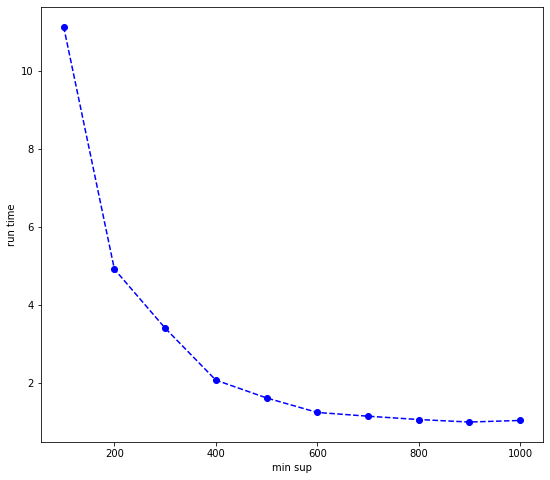

In [153]:
fig,ax = plt.subplots(figsize=(9,8))
ax.plot(minsup_list,runtimes,'bo--')
ax.set_xlabel("min sup")
ax.set_ylabel("run time")
ax.plot()

In [5]:
cb

,country,year,sex,age,suicides_no,population,gdp_for_year ($),gdp_per_capita ($),generation,Count
0,Albania,*,female,*,*,med,*,*,*,109
1,Albania,*,female,*,*,*,low,*,*,102
2,Albania,*,female,*,*,*,*,*,*,132
3,Albania,*,male,*,*,med,*,*,*,108
4,Albania,*,male,*,*,*,low,*,*,102
...,...,...,...,...,...,...,...,...,...,...
9379,*,*,*,*,*,*,*,*,Generation X,6408
9380,*,*,*,*,*,*,*,*,Generation Z,1470
9381,*,*,*,*,*,*,*,*,Millenials,5844
9382,*,*,*,*,*,*,*,*,Silent,6363


In [ ]:
import csv
import pandas as pd
import os




# BUC USING EXTERNAL MEMORY

External Merge Sort

In [ ]:
def merge_files(output_file, file1, file2, attr_idx):
    with open(file1, "r", newline="") as f1, open(file2, "r", newline="") as f2:
        reader1 = csv.reader(f1, delimiter=",")
        reader2 = csv.reader(f2, delimiter=",")
        writer = csv.writer(output_file)

        header1 = next(reader1)
        header2 = next(reader2)
        writer.writerow(header1)

        val1 = next(reader1, None)
        val2 = next(reader2, None)

        while val1 is not None and val2 is not None:
            if val1[attr_idx] <= val2[attr_idx]:
                writer.writerow(val1)
                val1 = next(reader1, None)
            else:
                writer.writerow(val2)
                val2 = next(reader2, None)

        while val1 is not None:
            writer.writerow(val1)
            val1 = next(reader1, None)

        while val2 is not None:
            writer.writerow(val2)
            val2 = next(reader2, None)

def external_merge_sort(filename, start, end, attr, columns, rows):
    if end - start < rows:
        temp = pd.read_csv(filename)
        temp.sort_values(attr, inplace=True)
        #temp.set_index(temp.columns[0], inplace=True)
        temp.to_csv(filename, index=False)
    else:
        mid = (start + end) // 2
        fp1 = f"{start}_{mid}_{attr}.csv"
        fp2 = f"{mid + 1}_{end}_{attr}.csv"
        f1=pd.read_csv(filename,nrows=mid-start+1)
        f2=pd.read_csv(filename,skiprows=range(1,mid-start+2))
        #f1.set_index(f1.columns[0], inplace=True)
        f1.to_csv(fp1, index=False)
        #f2.set_index(f2.columns[0], inplace=True)
        f2.to_csv(fp2, index=False)

        external_merge_sort(fp1, start, mid, attr, columns, rows)
        external_merge_sort(fp2, mid + 1, end, attr, columns, rows)

        with open(filename, "w", newline="") as output_file:
            merge_files(output_file, fp1, fp2, columns.index(attr))

        os.remove(fp1)
        os.remove(fp2)


In [230]:
def preprocess(df):
    def bin_and_label(df, column_name, bins, labels):
      df[column_name] = pd.cut(df[column_name], bins=bins, labels=labels)

    def drop_columns(df, columns):
      df.drop(columns=columns, inplace=True)

    drop_columns(df, ["country-year", "suicides/100k pop", "HDI for year","Unnamed: 0"])
    desc=df.describe()
    population_bins = [0, desc["population"]["25%"], desc["population"]["75%"], desc["population"]["max"]]
    population_labels = ["low", "med", "high"]
    bin_and_label(df, "population", bins=population_bins, labels=population_labels)

    suicide_bins = [i * 10 for i in range(int(desc["suicides_no"]["75%"] / 10) + 3)]
    suicide_bins.insert(0, -1)
    suicide_bins.append(int(desc["suicides_no"]["max"]) + 1)
    suicide_labels = ["({}-{})".format(suicide_bins[i] + 1, suicide_bins[i + 1]) for i in range(len(suicide_bins) - 1)]
    suicide_labels[-1] = "(>{})".format(suicide_bins[-2])
    bin_and_label(df, "suicides_no", bins=suicide_bins, labels=suicide_labels)

    gdp_year_bins = [0, desc[' gdp_for_year ($) ']["25%"], desc[' gdp_for_year ($) ']["75%"], desc[' gdp_for_year ($) ']["max"]]
    gdp_year_labels = ["low", "med", "high"]
    bin_and_label(df, " gdp_for_year ($) ", bins=gdp_year_bins, labels=gdp_year_labels)

    gdp_per_capita_bins = [i * 1000 for i in range(int(desc["gdp_per_capita ($)"]["75%"] / 1000) + 1)]
    gdp_per_capita_bins.append(int(desc["gdp_per_capita ($)"]["max"]))
    gdp_per_capita_labels = ["({}-{})".format(gdp_per_capita_bins[i], gdp_per_capita_bins[i + 1]) for i in range(len(gdp_per_capita_bins) - 1)]
    gdp_per_capita_labels[-1] = "(>{})".format(gdp_per_capita_bins[-2])
    bin_and_label(df, "gdp_per_capita ($)", bins=gdp_per_capita_bins, labels=gdp_per_capita_labels)
    return df

def sort_values(data,dims,chunk_size):
    data.to_csv("file.csv",index=False)
    external_merge_sort("file.csv", 1, len(data)-1, dims[0], dims, chunk_size)
    return pd.read_csv("file.csv")
    
def BUC(data, l, minsup,ans,dims,chunk_size):
    if len(dims) == 0:
        ans.append(copy.deepcopy(l))
        ans[-1].append(len(data))
        return
    data=sort_values(data,dims,chunk_size)

    def partition(data):
      req = np.array(data.iloc[:,0])
      data_counts = []
      last = 0
      if len(req) == 1:
          return [1]
      for i in range(len(req) - 1):
          if req[i] != req[i + 1]:
              data_counts.append(i-last+1)
              last = i+1
      data_counts.append(i-last+1)
      return data_counts

    data_counts = partition(data)
    k = 0
    for i,count in enumerate(data_counts):
        if count >= minsup:
            l.append(data.iloc[k,0])
            BUC(data.iloc[k:k + count, 1:], copy.deepcopy(l), minsup,ans,dims[1:],chunk_size)
            l.pop()
        k += count
    l.append("*")
    BUC(data.iloc[:, 1:], copy.deepcopy(l), minsup,ans,dims[1:],chunk_size)
    l.pop()

def BUC_RUN(f,blocks,min_sup):
    runtimes = []
    num_cubes = []
    df = preprocess(pd.read_csv(f))
    cols=copy.deepcopy(list(df.columns))
    for block in blocks:
        cp=copy.deepcopy(df)
        ans = []
        l = []
        start_time = time.time()
        BUC(cp, l, min_sup,ans,list(cp.columns),block)
        end_time = time.time() - start_time
        runtimes.append(end_time)
        num_cubes.append(len(ans))

    cols.append("Count")
    result = pd.DataFrame(ans,columns=cols)
    return result,runtimes,num_cubes



Block Size vs Runntime with Min Support 100

In [156]:
min_sup=100
block_size=[100,200,300,400,500,600,700,800,900,1000]
cubes,runtimes,num_cubes=BUC_RUN("master.csv",block_size,min_sup)

[]

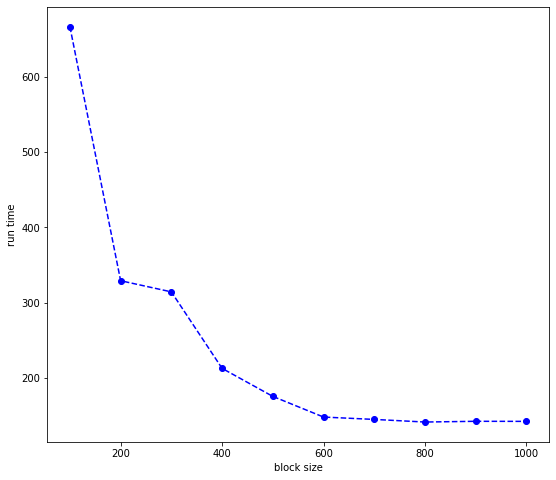

In [157]:
fig,ax = plt.subplots(figsize=(9,8))
ax.plot(block_size,runtimes,'bo--')
ax.set_xlabel("block size")
ax.set_ylabel("run time")
ax.plot()

Block Size vs Runntime with Min Support 500

[]

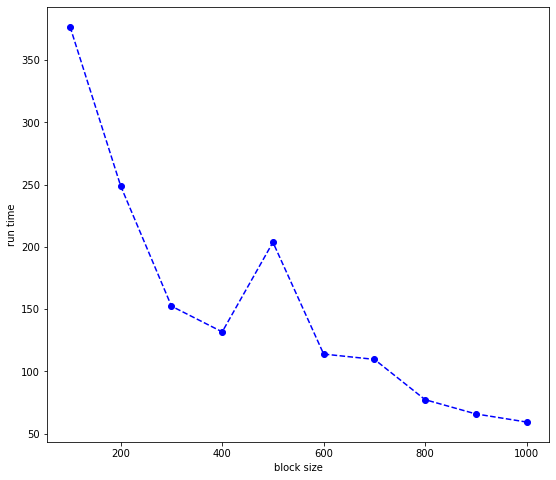

In [231]:
min_sup=500
block_size=[100,200,300,400,500,600,700,800,900,1000]
cubes,runtimes,num_cubes=BUC_RUN("master.csv",block_size,min_sup)
fig,ax = plt.subplots(figsize=(9,8))
ax.plot(block_size,runtimes,'bo--')
ax.set_xlabel("block size")
ax.set_ylabel("run time")
ax.plot()

Block Size vs Runntime with Min Support 1000

[]

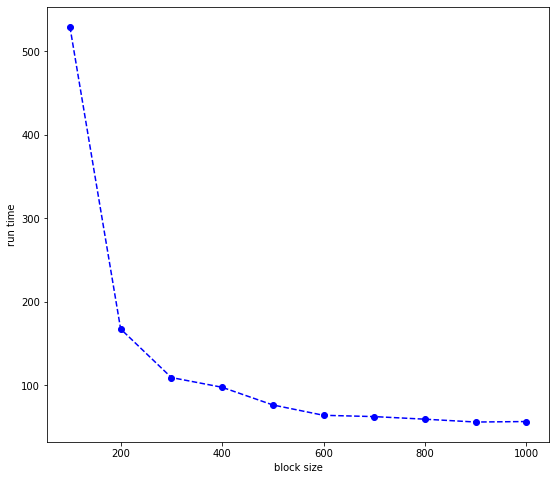

In [232]:
min_sup=1000
block_size=[100,200,300,400,500,600,700,800,900,1000]
cubes,runtimes,num_cubes=BUC_RUN("master.csv",block_size,min_sup)
fig,ax = plt.subplots(figsize=(9,8))
ax.plot(block_size,runtimes,'bo--')
ax.set_xlabel("block size")
ax.set_ylabel("run time")
ax.plot()

In [233]:
def BUC_RUN_FIXED(f,blocks_size,minsup_list):
    runtimes = []
    num_cubes = []
    df = preprocess(pd.read_csv(f))
    cols=copy.deepcopy(list(df.columns))
    for min_sup in minsup_list:
        cp=copy.deepcopy(df)
        ans = []
        l = []
        start_time = time.time()
        BUC(cp, l, min_sup,ans,list(cp.columns),blocks_size)
        end_time = time.time() - start_time
        runtimes.append(end_time)
        num_cubes.append(len(ans))

    cols.append("Count")
    result = pd.DataFrame(ans,columns=cols)
    return result,runtimes,num_cubes


minsup vs Runntime with block_size 100 

In [234]:
block_size=100
minsup_list = [100,200,300,400,500,600,700,800,900,1000]
cubes,runtimes,num_cubes=BUC_RUN_FIXED("master.csv",block_size,minsup_list)

[]

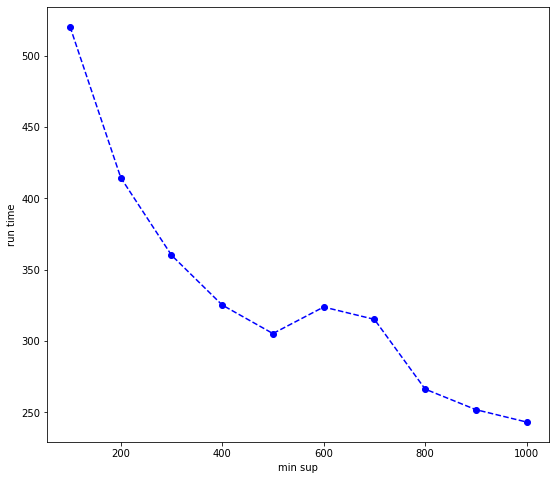

In [235]:
fig,ax = plt.subplots(figsize=(9,8))
ax.plot(minsup_list,runtimes,'bo--')
ax.set_xlabel("min sup")
ax.set_ylabel("run time")
ax.plot()

minsup vs Runntime with block_size 500 

In [236]:
block_size=500
minsup_list = [100,200,300,400,500,600,700,800,900,1000]
cubes,runtimes,num_cubes=BUC_RUN_FIXED("master.csv",block_size,minsup_list)

[]

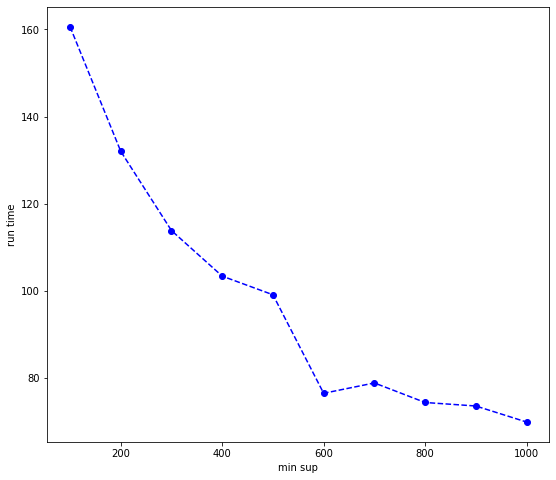

In [237]:
fig,ax = plt.subplots(figsize=(9,8))
ax.plot(minsup_list,runtimes,'bo--')
ax.set_xlabel("min sup")
ax.set_ylabel("run time")
ax.plot()

minsup vs Runntime with block_size 1000

In [238]:
block_size=1000
minsup_list = [100,200,300,400,500,600,700,800,900,1000]
cubes,runtimes,num_cubes=BUC_RUN_FIXED("master.csv",block_size,minsup_list)

[]

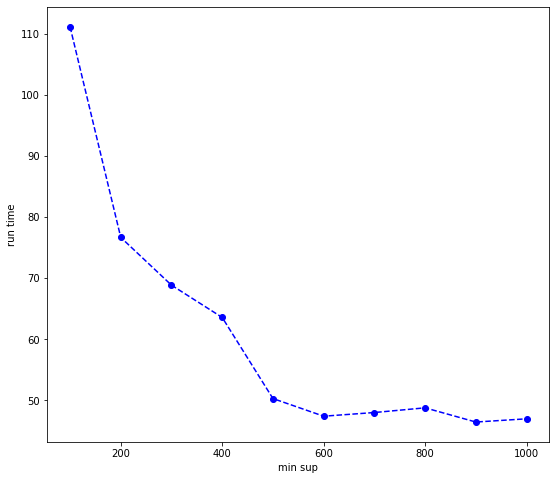

In [239]:
fig,ax = plt.subplots(figsize=(9,8))
ax.plot(minsup_list,runtimes,'bo--')
ax.set_xlabel("min sup")
ax.set_ylabel("run time")
ax.plot()

#  Attribute-oriented induction

* Here we have removed the the unique columns such as "Property_id", "Project_URL", "City_id","Listing_Category","Sub_urban_ID","Longitude","Latitude","builder_id","Locality_ID","description" as they provided less to no specific information about data
* Price,Price_per_unit_area and Sizes are divided into three group low,med,high where high is >75% med is >25% & <75% and low is <25%
* Posted on column is binned with bin size == 1 month
* listing domain score is binned to its nearest integer range 

In [7]:
def _preprocess(df):
    def bin_and_label(df, column_name, bins, labels):
      df[column_name] = pd.cut(df[column_name], bins=bins, labels=labels)

    def drop_columns(df, columns):
      df.drop(columns=columns, inplace=True)
    def add_values(val):
      all=val.split(' ')
      if all[1]=='months':
         return int(all[0])
      return 1
   
    drop_columns(df, ["Property_id", "Project_URL", "City_id","Listing_Category","Sub_urban_ID","Longitude","Latitude","builder_id","Locality_ID","description"])
    df['Price']=df['Price'].replace(r'\D', '', regex=True).astype(float)
    df['Size']=df['Size'].replace(r'\D', '', regex=True).astype(float)
    df['Price_per_unit_area']=df['Price_per_unit_area'].replace(r'\D', '', regex=True).astype(float)
    df['listing_domain_score']=df['listing_domain_score']
    df['Posted_On']=np.array([add_values(i) for i in df['Posted_On']])
    desc=df.describe()
    price_bins = [0, desc["Price"]["25%"], desc["Price"]["75%"], desc["Price"]["max"]]
    price_labels = ["low", "med", "high"]
    bin_and_label(df, "Price", bins=price_bins, labels=price_labels)
    pricepa_bins = [0, desc["Price_per_unit_area"]["25%"], desc["Price_per_unit_area"]["75%"], desc["Price_per_unit_area"]["max"]]
    pricepa_labels = ["low", "med", "high"]
    bin_and_label(df, "Price_per_unit_area", bins=pricepa_bins, labels=pricepa_labels)
    Size_bins = [0, desc["Size"]["25%"], desc["Size"]["75%"], desc["Size"]["max"]]
    Size_labels = ["low", "med", "high"]
    bin_and_label(df, "Size", bins=Size_bins, labels=Size_labels)
    score_bins = [i for i in range(int(desc["listing_domain_score"]["min"])-1,int(desc["listing_domain_score"]["max"])+2)]
    score_labels = ["({}-{} months)".format(score_bins[i], score_bins[i + 1]) for i in range(len(score_bins) - 1)]
    score_labels[-1] = "(>{} months)".format(score_bins[-2])
    bin_and_label(df, "listing_domain_score", bins=score_bins, labels=score_labels)
    p_bins = [i for i in range(int(desc["Posted_On"]["min"])-1,int(desc["Posted_On"]["max"])+2)]
    p_labels = ["({}-{})".format(p_bins[i], p_bins[i + 1]) for i in range(len(p_bins) - 1)]
    p_labels[-1] = "(>{})".format(p_bins[-2])
    bin_and_label(df, "Posted_On", bins=p_bins, labels=p_labels)
    
    return df

df=pd.read_csv("cleaned_data.csv")

/tmp/ipykernel_14983/1808962962.py:40: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("cleaned_data.csv")


In [8]:
new_df=_preprocess(df)

In [9]:
new_df

,Property_Name,Property_type,Property_status,Price_per_unit_area,Posted_On,Builder_name,Property_building_status,City_name,No_of_BHK,Locality_Name,...,Sub_urban_name,is_furnished,listing_domain_score,is_plot,is_RERA_registered,is_Apartment,is_ready_to_move,is_commercial_Listing,is_PentaHouse,is_studio
0,Arkiton Luxe,Apartment,Under Construction,low,(0-1),Arkiton life Space,ACTIVE,Ahmedabad,3 BHK,Bopal,...,Ahmedabad West,Unfurnished,(3-4 months),False,True,True,False,False,False,False
1,Keshav Akshar Ocean Pearl,Apartment,Under Construction,med,(0-1),Keshav Narayan Group,ACTIVE,Ahmedabad,4 BHK,Ambli,...,Ahmedabad West,Unfurnished,(3-4 months),False,True,True,False,False,False,False
2,Vishwa Opulence,Apartment,Ready to move,med,(0-1),Vishwa Developers Ahmedabad,ACTIVE,Ahmedabad,3 BHK,Naryanpura,...,Ahmedabad West,Unfurnished,(3-4 months),False,False,True,True,False,False,False
3,Satyam Sarjan,Apartment,Ready to move,low,(0-1),Satyam Developers,ACTIVE,Ahmedabad,2 BHK,Changodar,...,Ahmedabad South,Unfurnished,(3-4 months),False,False,True,True,False,False,False
4,Navkar Sunflower,Apartment,Under Construction,med,(0-1),Navkar Buildcon Ahmedabad,ACTIVE,Ahmedabad,3 BHK,Shilaj,...,Ahmedabad West,Unfurnished,(3-4 months),False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143703,Rajlaxmi RaajLaxmi Towers,Apartment,Under Construction,med,(3-4),Rajlaxmi Developers Mumbai,ACTIVE,Mumbai,1 BHK,Vasai,...,Mira Road and Beyond,Unfurnished,(3-4 months),False,True,True,False,False,False,False
143704,Rajlaxmi RaajLaxmi Towers,Apartment,Under Construction,med,(3-4),Rajlaxmi Developers Mumbai,ACTIVE,Mumbai,1 BHK,Vasai,...,Mira Road and Beyond,Unfurnished,(3-4 months),False,True,True,False,False,False,False
143705,Rajlaxmi RaajLaxmi Towers,Apartment,Under Construction,med,(3-4),Rajlaxmi Developers Mumbai,ACTIVE,Mumbai,1 BHK,Vasai,...,Mira Road and Beyond,Unfurnished,(3-4 months),False,True,True,False,False,False,False
143706,Rajlaxmi RaajLaxmi Towers,Apartment,Under Construction,med,(3-4),Rajlaxmi Developers Mumbai,ACTIVE,Mumbai,2 BHK,Vasai,...,Mira Road and Beyond,Unfurnished,(3-4 months),False,True,True,False,False,False,False
